In [31]:
import numpy as np
import pandas as pd
from datetime import time

def encode_time_features(datetime_index, market_type='A'):
    """
    高级时间特征编码函数，特别优化股票开盘/收盘效应
    :param datetime_index: 日期时间索引 (pandas.DatetimeIndex)
    :param market_type: 市场类型 ('A'表示A股)
    :return: DataFrame包含丰富的时间特征
    """
    if not isinstance(datetime_index, pd.DatetimeIndex):
        raise ValueError("输入必须是DatetimeIndex")
    
    # 创建特征DataFrame
    features = pd.DataFrame(index=datetime_index)
    
    # 基础时间特征
    features['hour'] = datetime_index.hour
    features['minute'] = datetime_index.minute
    features['day_of_week'] = datetime_index.dayofweek
    features['day_of_month'] = datetime_index.day
    features['week_of_year'] = datetime_index.isocalendar().week
    features['month'] = datetime_index.month
    
    # 计算总分钟数（自0:00起）
    total_minutes = features['hour'] * 60 + features['minute']
    
    # ===== 1. 通用时间周期编码 =====
    # 交易日分钟进度（0-1表示交易日进度）
    features['trading_progress'] = 0.0
    
    # 不同市场的交易时间
    if market_type == 'A':  # A股市场
        # 计算自9:30起的分钟数
        morning_minutes = (features['hour'] - 9) * 60 + features['minute'] - 30
        afternoon_minutes = (features['hour'] - 13) * 60 + features['minute']
        
        # 早盘进度 (9:30-11:30)
        morning_mask = (features['hour'] >= 9) & (features['hour'] < 11) | (
            (features['hour'] == 11) & (features['minute'] < 30)
        )
        features.loc[morning_mask, 'trading_progress'] = np.clip(morning_minutes[morning_mask] / 120, 0, 1)
        
        # 午盘进度 (13:00-15:00)
        afternoon_mask = (features['hour'] >= 13) & (features['hour'] < 15)
        features.loc[afternoon_mask, 'trading_progress'] = np.clip(afternoon_minutes[afternoon_mask] / 120, 0, 1)
    else:  # 美股等市场
      pass
      # 实现类似逻辑
    
    # ===== 2. 关键时段标记 =====
    features['is_opening'] = 0  # 开盘前30分钟 (9:30-10:00)
    features['is_early_morning'] = 0  # 早盘时段 (10:00-11:00)
    features['is_midday'] = 0  # 午盘时段 (13:00-14:00)
    features['is_late_afternoon'] = 0  # 尾盘时段 (14:30-15:00)
    features['is_closing'] = 0  # 收盘前15分钟
    
    # A股市场关键时段
    if market_type == 'A':
        # 开盘时段标记
        opening_mask = (features['hour'] == 9) & (features['minute'] >= 30) | (
            (features['hour'] == 10) & (features['minute'] == 0)
        )
        features.loc[opening_mask, 'is_opening'] = 1
        
        # 早盘时段
        early_morning_mask = (features['hour'] == 10) & (features['minute'] > 0) | (
            (features['hour'] == 10) & (features['minute'] <= 59
        ))
        features.loc[early_morning_mask, 'is_early_morning'] = 1
        
        # 午盘时段
        midday_mask = (features['hour'] == 13) | (
            (features['hour'] == 14) & (features['minute'] == 0
        ))
        features.loc[midday_mask, 'is_midday'] = 1
        
        # 尾盘时段
        late_afternoon_mask = (features['hour'] == 14) & (features['minute'] >= 30) & (features['minute'] < 57)
        features.loc[late_afternoon_mask, 'is_late_afternoon'] = 1
        
        # 收盘前
        closing_mask = (features['hour'] == 14) & (features['minute'] >= 57) | (
            (features['hour'] == 14) & (features['minute'] == 58
        )) | (features['hour'] == 14) & (features['minute'] == 59)
        features.loc[closing_mask, 'is_closing'] = 1
    
    # ===== 3. 时间周期性编码 =====
    # 小时级周期特征（正弦/余弦）
    features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
    features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)
    
    # 分钟级周期特征
    features['minute_sin'] = np.sin(2 * np.pi * total_minutes / (24 * 60))
    features['minute_cos'] = np.cos(2 * np.pi * total_minutes / (24 * 60))
    
    # ===== 4. 高级复合特征 =====
    # 开盘效应强度（非线性函数）
    features['opening_effect'] = np.exp(-2 * (features['trading_progress'] ** 2))
    
    # 收盘效应强度（线性增长）
    features['closing_effect'] = np.clip(3 * (features['trading_progress'] - 0.7), 0, 1)
    
    # ===== 5. 交易策略相关的特殊特征 =====
    # 开盘波动预期
    features['opening_volatility_expectation'] = 0
    features.loc[features['is_opening'] == 1, 'opening_volatility_expectation'] = 1
    
    # 午盘流动性特征
    features['midday_liquidity'] = 0
    features.loc[features['is_midday'] == 1, 'midday_liquidity'] = 1
    
    # 尾盘资金流特征
    features['late_afternoon_flow'] = np.where(
        features['is_late_afternoon'] == 1,
        features['trading_progress'] * 0.8 + 0.2,
        0
    )
    
    # ===== 6. 季节性/特殊日特征 =====
    # 月度效应（月底资金流动）
    features['month_end_effect'] = np.where(
        features['day_of_month'] >= 25,
        (features['day_of_month'] - 25) / 6,  # 25-31线性增长
        0
    )
    
    # 周五效应
    features['friday_effect'] = (features['day_of_week'] == 4).astype(int)
    
    return features

def prepare_time_features_for_rl(features):
    """准备适用于RL观测空间的时间特征"""
    from sklearn.preprocessing import MinMaxScaler
    import copy
    
    # 创建特征副本防止污染原始数据
    rl_features = copy.deepcopy(features)
    
    # 分层处理不同类型特征
    # 第一层：不需要处理的特征（二值标记、三角函数）
    safe_features = [
        'is_opening', 'is_early_morning', 'is_midday', 
        'is_late_afternoon', 'is_closing', 'friday_effect',
        'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'
    ]
    
    # 第二层：需要缩放到[0,1]的比例特征
    scaler = MinMaxScaler()
    proportional_features = [
        'trading_progress', 'opening_effect', 'closing_effect',
        'month_end_effect', 'late_afternoon_flow'
    ]
    rl_features[proportional_features] = scaler.fit_transform(
        rl_features[proportional_features]
    )
    
    # 第三层：特殊处理计数特征
    # 将计数特征转换为比例
    rl_features['day_of_week'] /= 6.0      # 周一=0/6≈0.0, 周五=4/6≈0.67, 周六=5/6≈0.83
    rl_features['day_of_month'] /= 31.0     # 1号=0.032, 15号=0.484, 31号=1.0
    rl_features['week_of_year'] /= 52.0
    rl_features['month'] /= 12.0
    
    # 第四层：时间点特征的编码优化
    # 使用复合时间进度替代原始时间计数
    rl_features['composite_time'] = (
        0.7 * rl_features['trading_progress'] + 
        0.3 * ((rl_features['hour'] * 60 + rl_features['minute']) / (16 * 60))
    )
    # 移除原始计数特征
    rl_features = rl_features.drop(columns=['hour', 'minute'])
    
    return rl_features

In [85]:
from pathlib import Path
import pandas as pd
symbol='300059'
csv_path = Path("../luckymodel/raw_data/csv/m5") / f"{symbol}.csv"
df = pd.read_csv(csv_path, parse_dates=["date"], index_col="date")
df = (
      df.sort_index()
    .dropna()
    .drop_duplicates()
)
df

,open,high,low,close,amount,volume
date,,,,,,
2023-01-18 09:35:00,22.51,22.73,22.51,22.64,233601520.0,10325200
2023-01-18 09:40:00,22.64,22.73,22.61,22.72,99436208.0,4387400
2023-01-18 09:45:00,22.72,22.73,22.61,22.61,77754432.0,3429000
2023-01-18 09:50:00,22.62,22.66,22.60,22.64,54280716.0,2398400
2023-01-18 09:55:00,22.65,22.70,22.63,22.64,55326888.0,2441300
...,...,...,...,...,...,...
2024-05-16 14:40:00,12.80,12.81,12.78,12.81,77598984.0,6063400
2024-05-16 14:45:00,12.81,12.82,12.80,12.80,35336256.0,2759000
2024-05-16 14:50:00,12.80,12.81,12.79,12.80,36858488.0,2879100


In [34]:
# 假设df是包含DatetimeIndex的DataFrame
time_features = encode_time_features(df.index, market_type='A')
prepare_time_features=prepare_time_features_for_rl(time_features)
prepare_time_features


,day_of_week,day_of_month,week_of_year,month,trading_progress,is_opening,is_early_morning,is_midday,is_late_afternoon,is_closing,...,minute_sin,minute_cos,opening_effect,closing_effect,opening_volatility_expectation,midday_liquidity,late_afternoon_flow,month_end_effect,friday_effect,composite_time
date,,,,,,,,,,,,,,,,,,,,,
2023-01-18 09:35:00,0.333333,0.580645,0.057692,0.083333,0.043478,1,0,0,0,0,...,0.591310,-0.806445,0.995877,0.000000,1,0,0.000000,0.0,0,0.210122
2023-01-18 09:40:00,0.333333,0.580645,0.057692,0.083333,0.086957,1,0,0,0,0,...,0.573576,-0.819152,0.983593,0.000000,1,0,0.000000,0.0,0,0.242120
2023-01-18 09:45:00,0.333333,0.580645,0.057692,0.083333,0.130435,1,0,0,0,0,...,0.555570,-0.831470,0.963402,0.000000,1,0,0.000000,0.0,0,0.274117
2023-01-18 09:50:00,0.333333,0.580645,0.057692,0.083333,0.173913,1,0,0,0,0,...,0.537300,-0.843391,0.935718,0.000000,1,0,0.000000,0.0,0,0.306114
2023-01-18 09:55:00,0.333333,0.580645,0.057692,0.083333,0.217391,1,0,0,0,0,...,0.518773,-0.854912,0.901098,0.000000,1,0,0.000000,0.0,0,0.338111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16 14:40:00,0.500000,0.516129,0.384615,0.416667,0.869565,0,0,0,1,0,...,-0.642788,-0.766044,0.107089,0.516129,0,0,0.896552,0.0,0,0.883696
2024-05-16 14:45:00,0.500000,0.516129,0.384615,0.416667,0.913043,0,0,0,1,0,...,-0.659346,-0.751840,0.067731,0.677419,0,0,0.931034,0.0,0,0.915693
2024-05-16 14:50:00,0.500000,0.516129,0.384615,0.416667,0.956522,0,0,0,1,0,...,-0.675590,-0.737277,0.032052,0.838710,0,0,0.965517,0.0,0,0.947690


In [ ]:

# 将特征合并到原始DataFrame
df = pd.concat([df, time_features], axis=1)
print(len(df.columns),df.columns)
df

In [24]:
# 删除高度相关特征
corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
dff =df.copy()
dff.drop(to_drop, axis=1, inplace=True)
print(len(dff.columns),dff.columns)

18 Index(['open', 'amount', 'hour', 'minute', 'day_of_week', 'day_of_month',
       'week_of_year', 'trading_progress', 'is_opening', 'is_early_morning',
       'is_midday', 'is_late_afternoon', 'is_closing', 'hour_cos',
       'minute_cos', 'closing_effect', 'month_end_effect', 'friday_effect'],
      dtype='object')


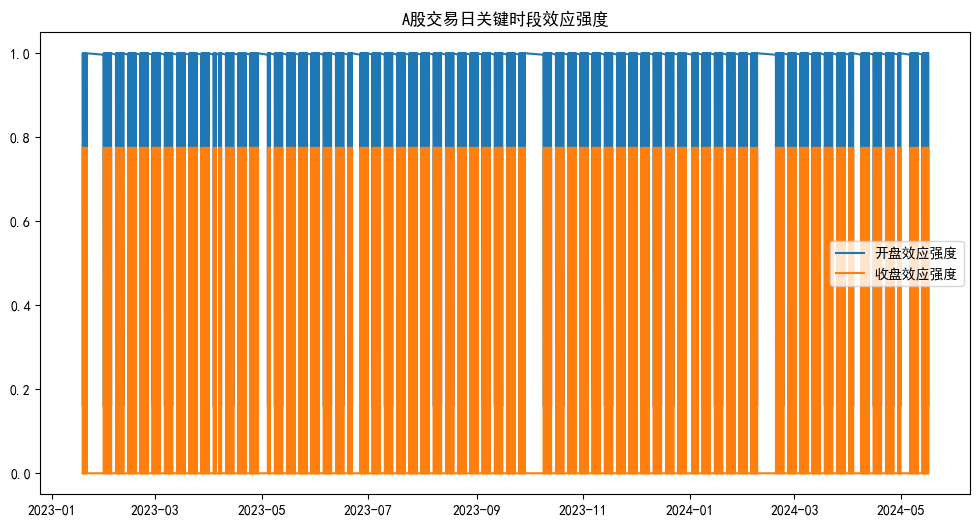

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# 可视化开盘效应特征
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['opening_effect'], label='开盘效应强度')
plt.plot(df.index, df['closing_effect'], label='收盘效应强度')
plt.title('A股交易日关键时段效应强度')
plt.legend()
plt.show()

Text(0, 0.5, '实际波动率')

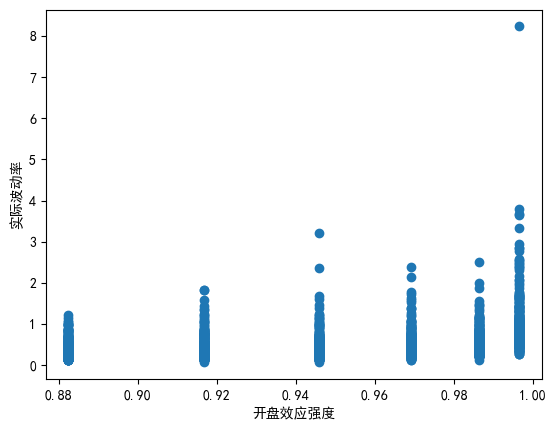

In [26]:
# 开盘效应与波动率关系
df['price_range'] = df['high'] - df['low']
df['volatility'] = df['price_range'] / df['close'].shift(1) * 100
opening_data = df[df['is_opening'] == 1]
plt.scatter(opening_data['opening_effect'], opening_data['volatility'])
plt.xlabel('开盘效应强度')
plt.ylabel('实际波动率')

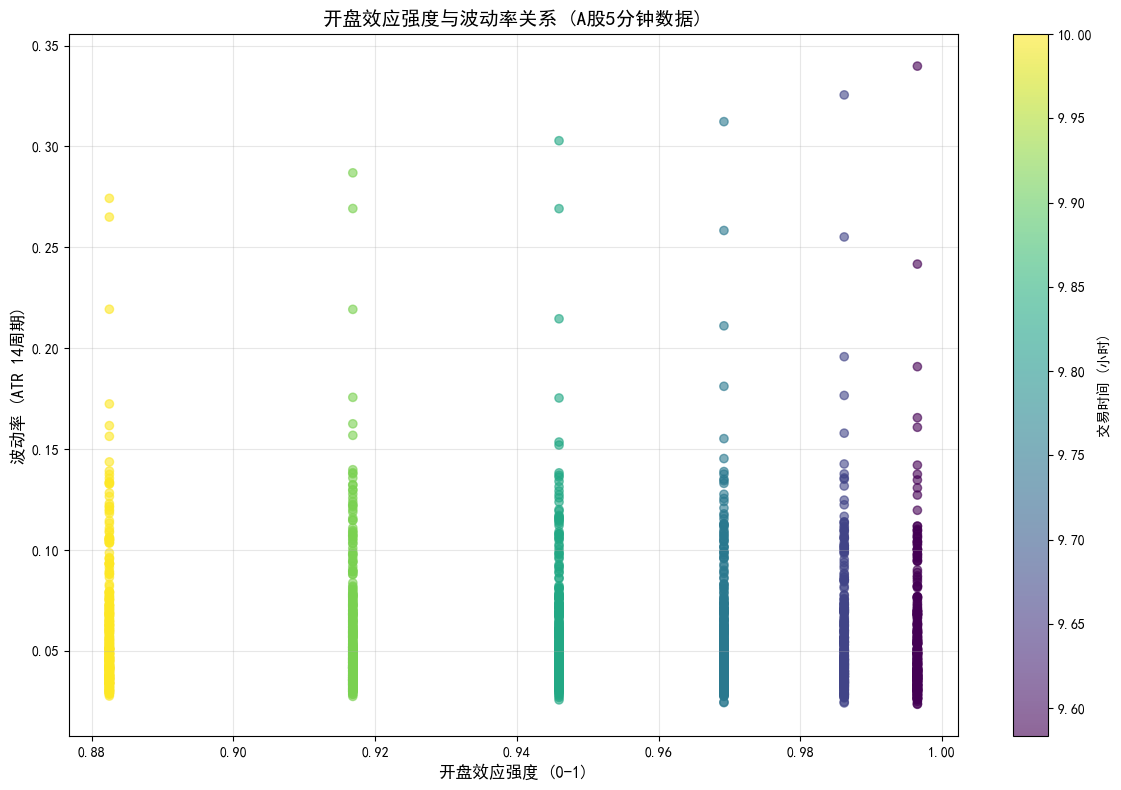

开盘效应与波动率的相关系数: -0.06


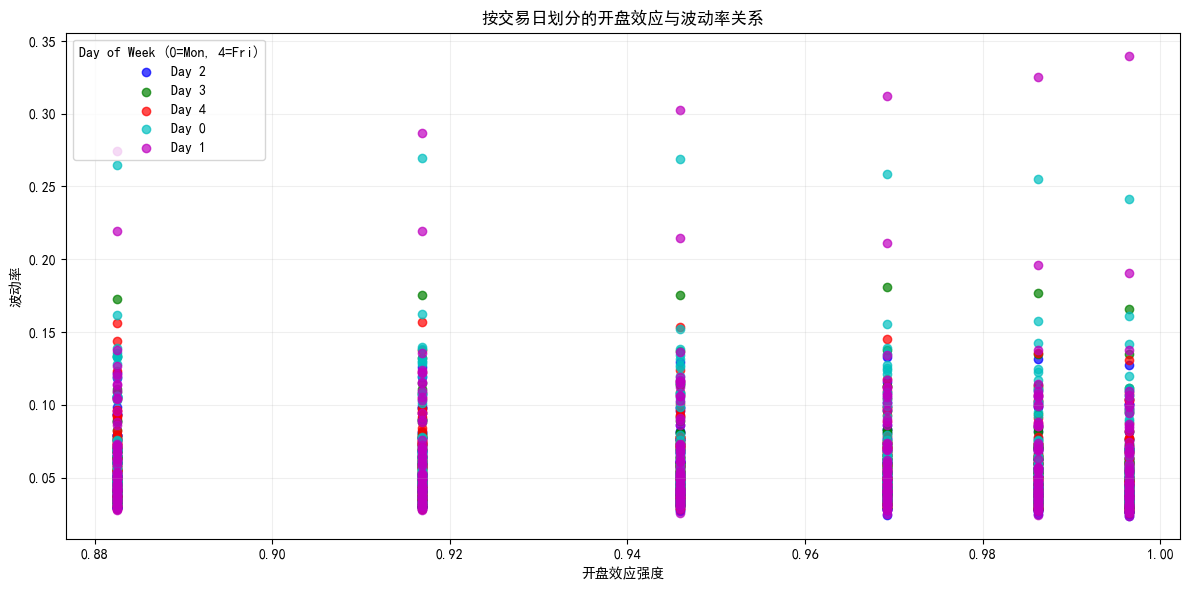

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from talib import ATR

# 假设df是包含OHLCV数据的DataFrame，索引为DatetimeIndex
# # 步骤1: 添加时间特征（如果尚未添加）
# df = df.join(encode_time_features(df.index, market_type='A'))

# 步骤2: 计算波动率 - 选择合适的方法
def calculate_volatility(df, method='atr', period=14):
    """
    计算股票波动率
    :param df: 包含OHLCV数据的DataFrame
    :param method: 计算方法 ('atr', 'range', 'std')
    :param period: 计算周期
    :return: 添加波动率列的DataFrame
    """
    if method == 'atr':
        # 使用ATR计算真实波动范围
        df['volatility'] = ATR(df['high'], df['low'], df['close'], timeperiod=period)
    elif method == 'range':
        # 使用当日价格范围计算
        df['price_range'] = df['high'] - df['low']
        df['volatility'] = df['price_range'] / df['close'].shift(1) * 100
    elif method == 'std':
        # 使用收益率标准差计算
        df['returns'] = df['close'].pct_change()
        df['volatility'] = df['returns'].rolling(window=period).std() * np.sqrt(24 * 12)  # 年化波动率
    
    # 填充NaN值
    df['volatility'].bfill()
    return df

# 计算波动率（推荐使用ATR方法）
df = calculate_volatility(df, method='atr', period=14)

# 步骤3: 提取开盘时段数据
opening_data = df[df['is_opening'] == 1].copy()

# 步骤4: 可视化开盘效应与波动率关系
plt.figure(figsize=(12, 8))

# 散点图
plt.scatter(
    opening_data['opening_effect'], 
    opening_data['volatility'],
    alpha=0.6,
    c=opening_data.index.hour + opening_data.index.minute/60,  # 按时间着色
    cmap='viridis'
)

# 添加色标
plt.colorbar(label='交易时间 (小时)')

# 添加趋势线
z = np.polyfit(opening_data['opening_effect'], opening_data['volatility'], 1)
p = np.poly1d(z)
plt.plot(
    opening_data['opening_effect'], 
    p(opening_data['opening_effect']),
    "r--", 
    linewidth=2
)

# 添加标签和标题
plt.title('开盘效应强度与波动率关系 (A股5分钟数据)', fontsize=14)
plt.xlabel('开盘效应强度 (0-1)', fontsize=12)
plt.ylabel('波动率 (ATR 14周期)', fontsize=12)
plt.grid(alpha=0.3)

# 添加关键时间点标记
key_times = {
    "9:30": 0.0,
    "9:40": 0.2,
    "9:50": 0.4,
    "10:00": 0.6
}

for time_str, pos in key_times.items():
    plt.annotate(
        time_str, 
        xy=(pos, p(pos)), 
        xytext=(pos, p(pos) + 0.1),
        arrowprops=dict(facecolor='black', shrink=0.05),
        horizontalalignment='center'
    )

plt.tight_layout()
plt.show()

# 步骤5: 分析开盘效应与波动率的相关性
correlation = opening_data['opening_effect'].corr(opening_data['volatility'])
print(f"开盘效应与波动率的相关系数: {correlation:.2f}")

# 高级分析：按不同交易日类型分组
if 'day_of_week' in opening_data.columns:
    plt.figure(figsize=(12, 6))
    colors = ['b', 'g', 'r', 'c', 'm']
    for i, day in enumerate(opening_data['day_of_week'].unique()):
        day_data = opening_data[opening_data['day_of_week'] == day]
        plt.scatter(
            day_data['opening_effect'], 
            day_data['volatility'], 
            alpha=0.7,
            color=colors[i],
            label=f'Day {day}'
        )
    
    plt.legend(title='Day of Week (0=Mon, 4=Fri)')
    plt.title('按交易日划分的开盘效应与波动率关系')
    plt.xlabel('开盘效应强度')
    plt.ylabel('波动率')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

In [38]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay

def add_prev_close_robust(df, market='A', trading_hours=(('09:30', '11:30'), ('13:00', '15:00'))):
    """
    鲁棒性最强的前收添加方法（专为高频数据优化）
    使用时间索引（无需单独datetime列）
    
    参数:
        df: DataFrame，时间索引必须是DatetimeIndex，需包含列['open', 'high', 'low', 'close', 'volume']
        market: 市场类型（'A'表示A股，'US'表示美股）
        trading_hours: 交易时间段（元组格式）
    
    返回:
        添加了prev_close列的DataFrame（保留原始索引）
    """
    # 0. 验证索引类型
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame索引必须是DatetimeIndex")
    
    # 1. 创建副本并确保索引排序
    df = df.copy()
    df = df.sort_index()
    
    # 2. 交易日识别函数（根据市场类型）
    def get_trading_date(dt):
        """根据市场规则确定交易日"""
        # A股：以收盘时间确定归属日（15点后算次日）
        if market == 'A':
            if dt.time() >= pd.Timestamp('15:00:00').time():
                return (dt + BDay(1)).date()
            return dt.date()
        # 美股：以美东时间收盘时间确定归属日
        elif market == 'US':
            if dt.time() >= pd.Timestamp('16:00:00').time():
                return (dt + BDay(1)).date()
            return dt.date()
        # 默认处理
        return dt.date()
    
    # 3. 提取日期信息并识别有效交易日
    df = df.reset_index() if 'datetime' in df.columns else df
    df['__date__'] = df.index.map(get_trading_date)
    
    # 4. 构建完整交易日历
    trading_dates = sorted(df['__date__'].unique())
    min_date, max_date = min(trading_dates), max(trading_dates)
    calendar = pd.date_range(min_date, max_date, freq='B').date
    
    # 5. 创建每日特征
    daily_data = []
    for date in calendar:
        date_mask = df['__date__'] == date
        if date_mask.any():
            # 取当日最后一根K线的收盘价
            last_bar = df.loc[date_mask].iloc[-1]
            daily_data.append({
                '__date__': date,
                'daily_close': last_bar['close']
            })
        else:
            daily_data.append({'__date__': date, 'daily_close': np.nan})
    
    daily_df = pd.DataFrame(daily_data)
    # 前收=前一日收盘价
    daily_df['prev_close'] = daily_df['daily_close'].shift(1)
    
    # 6. 映射到原始数据
    prev_close_map = daily_df.set_index('__date__')['prev_close'].to_dict()
    df['prev_close'] = df['__date__'].map(prev_close_map)
    
    # 7. 交易日内部填充
    # 用当日第一个有效prev_close填充全天
    first_prev_close = df.groupby('__date__')['prev_close'].transform('first')
    has_prev = first_prev_close.notna()
    df.loc[has_prev, 'prev_close'] = first_prev_close
    
    # 8. 边界处理
    df['prev_close'] = df['prev_close'].ffill().bfill()
    
    # 9. 计算相关特征
    df['day_open_gap'] = (df['open'] - df['prev_close']) / df['prev_close']
    
    # 10. 清理临时列并恢复索引
    df = df.drop(columns=['__date__'])
    return df

==== 关键数据点验证 ====
首日前收: 22.7
开盘缺口均值: -0.0010722557020522807


<Axes: title={'center': '收盘价与前收对比'}, xlabel='date'>

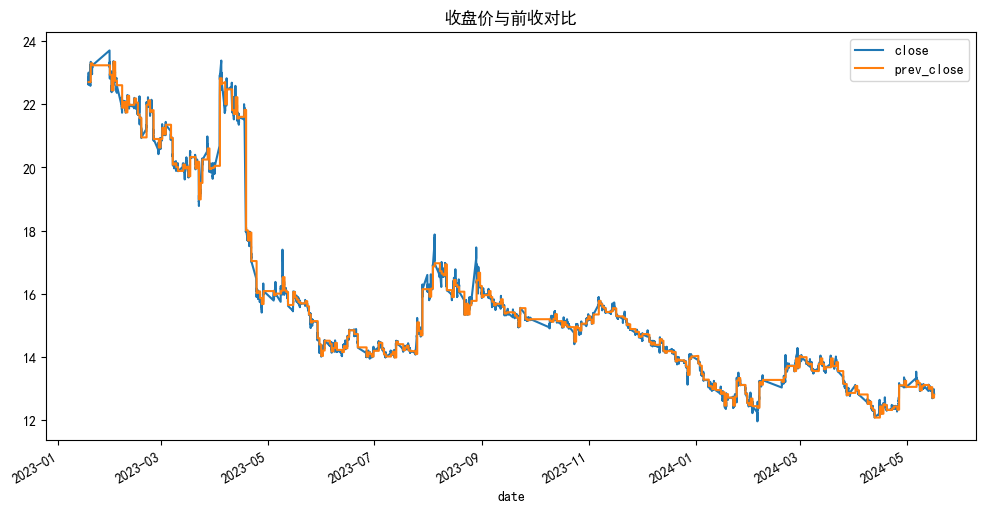

In [41]:
# 添加前收（使用时间索引）
df_with_prev = add_prev_close_robust(df, market='A')

# 结果验证
print("==== 关键数据点验证 ====")
print("首日前收:", df_with_prev['prev_close'].iloc[0])
print("开盘缺口均值:", df_with_prev['day_open_gap'].mean())

# 可视化检查
df_with_prev[['close', 'prev_close']].plot(title="收盘价与前收对比", figsize=(12, 6))

In [43]:
df

,open,high,low,close,amount,volume
date,,,,,,
2023-01-18 09:35:00,22.51,22.73,22.51,22.64,233601520.0,10325200
2023-01-18 09:40:00,22.64,22.73,22.61,22.72,99436208.0,4387400
2023-01-18 09:45:00,22.72,22.73,22.61,22.61,77754432.0,3429000
2023-01-18 09:50:00,22.62,22.66,22.60,22.64,54280716.0,2398400
2023-01-18 09:55:00,22.65,22.70,22.63,22.64,55326888.0,2441300
...,...,...,...,...,...,...
2024-05-16 14:40:00,12.80,12.81,12.78,12.81,77598984.0,6063400
2024-05-16 14:45:00,12.81,12.82,12.80,12.80,35336256.0,2759000
2024-05-16 14:50:00,12.80,12.81,12.79,12.80,36858488.0,2879100


In [91]:
# df['prev_close'] = df.groupby(pd.Grouper(freq='D'))['close'].transform('last').shift(1)
# df = df.assign(trade_date=df.index.date)
# daily_last_close = df.groupby('trade_date')['close'].last()
# df['prev_close'] = df['trade_date'].map(daily_last_close.shift())
# df.drop(columns=['trade_date'], inplace=True)

df['yestday_close'] = (
    df['close'].resample('D').last()  # 获取每日收盘价
    .shift()                         # 前一日收盘价
    .reindex(df.index, method='ffill')  # 填充到所有bar
)

# 填充首日
if df['yestday_close'].isna().any():
    first_day = df.index.min().date()
    df.loc[df.index.date == first_day, 'yestday_close'] = df.loc[df.index.date == first_day, 'open'].iloc[0]

df['pct_change'] = (df['close'] - df['yestday_close']) / df['yestday_close'] * 100
# df.tail(50)

In [97]:
def calculate_limit_status(df, stock_type='main'):
    """计算涨停/跌停状态
    
    Parameters:
        df: 包含pct_change的DataFrame
        stock_type: 股票类型 ('main'-主板, 'star'-科创板, 'gem'-创业板)
    """
    # 设置涨跌幅限制
    limit_map = {
        'main': 10.0,   # 主板
        'star': 20.0,   # 科创板
        'gem': 20.0     # 创业板
    }
    limit_pct = limit_map.get(stock_type, 10.0)
    
    # 初始化列
    df['is_up_limit'] = False
    df['is_down_limit'] = False
    
    # 计算涨停/跌停 (考虑浮点数精度问题)
    epsilon = 1e-6  # 浮点误差容忍度
    df.loc[df['pct_change'] >= (limit_pct - epsilon), 'is_up_limit'] = True
    df.loc[df['pct_change'] <= (-limit_pct + epsilon), 'is_down_limit'] = True
    
    # 处理ST股票(5%限制)
    if 'is_st' in df.columns:  # 假设有ST标志列
        st_mask = df['is_st'] == True
        df.loc[st_mask & (df['pct_change'] >= (5.0 - epsilon)), 'is_up_limit'] = True
        df.loc[st_mask & (df['pct_change'] <= (-5.0 + epsilon)), 'is_down_limit'] = True
    
    return df

# 应用函数
df = calculate_limit_status(df, stock_type='main')
df[df["is_up_limit"] | df["is_down_limit"]]


,open,high,low,close,amount,volume,yestday_close,pct_change,is_up_limit,is_down_limit
date,,,,,,,,,,
2023-04-18 09:35:00,18.12,18.29,18.01,18.25,707308928.0,38913600,21.83,-16.399450,False,True
2023-04-18 09:40:00,18.25,18.26,18.12,18.26,276229728.0,15174700,21.83,-16.353642,False,True
2023-04-18 09:45:00,18.27,18.37,18.23,18.33,341778752.0,18680500,21.83,-16.032982,False,True
2023-04-18 09:50:00,18.34,18.34,18.16,18.16,254679536.0,13954800,21.83,-16.811727,False,True
2023-04-18 09:55:00,18.16,18.21,18.13,18.18,158078416.0,8698800,21.83,-16.720110,False,True
2023-04-18 10:00:00,18.18,18.18,18.07,18.11,196110304.0,10828700,21.83,-17.040770,False,True
2023-04-18 10:05:00,18.11,18.16,18.10,18.13,111912200.0,6172400,21.83,-16.949153,False,True
2023-04-18 10:10:00,18.12,18.13,18.08,18.11,110074432.0,6080900,21.83,-17.040770,False,True
2023-04-18 10:15:00,18.11,18.19,18.09,18.17,98014272.0,5405800,21.83,-16.765918,False,True


In [42]:
df_with_prev

,open,high,low,close,amount,volume,prev_close,day_open_gap
date,,,,,,,,
2023-01-18 09:35:00,22.51,22.73,22.51,22.64,233601520.0,10325200,22.70,-0.008370
2023-01-18 09:40:00,22.64,22.73,22.61,22.72,99436208.0,4387400,22.70,-0.002643
2023-01-18 09:45:00,22.72,22.73,22.61,22.61,77754432.0,3429000,22.70,0.000881
2023-01-18 09:50:00,22.62,22.66,22.60,22.64,54280716.0,2398400,22.70,-0.003524
2023-01-18 09:55:00,22.65,22.70,22.63,22.64,55326888.0,2441300,22.70,-0.002203
...,...,...,...,...,...,...,...,...
2024-05-16 14:40:00,12.80,12.81,12.78,12.81,77598984.0,6063400,12.72,0.006289
2024-05-16 14:45:00,12.81,12.82,12.80,12.80,35336256.0,2759000,12.72,0.007075
2024-05-16 14:50:00,12.80,12.81,12.79,12.80,36858488.0,2879100,12.72,0.006289
